## Setup

In [1]:
%matplotlib inline

In [2]:
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset, BankDataset

In [3]:
from aif360.datasets import StandardDataset
StandardDataset??

In [4]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGRMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo

# Metrics
from aif360.metrics import BinaryLabelDatasetMetric

# Bias insertion
from oversample import label_bias, selection_bias 
from metrics_utils import get_orig_model_metrics

## Arguments & Initializations

In [5]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade ")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")

_StoreAction(option_strings=['-o', '--os'], dest='os', nargs=None, const=None, default=2, type=None, choices=None, required=False, help='oversample mode: 1: privi unfav 2: unpriv fav', metavar=None)

In [6]:
import sys
sys.argv = ['']
args = vars(ap.parse_args())

In [7]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2}

In [8]:
DATASET = "bank"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = int(args["os"])

In [9]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 3 

# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

egr_metrics = defaultdict(list) 
egr_mia_metrics = defaultdict(list) 


pr_orig_metrics = defaultdict(list) 
cpp_metrics = defaultdict(list) 
ro_metrics = defaultdict(list) 

## Loading & Splitting Dataset

In [10]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

# training data split ratio
p = 0.5

In [11]:
dataset_orig.features.shape

(30488, 57)

In [12]:
privileged_groups

[{'age': 1}]

In [13]:
# split dataset into train, validation, and test
dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
dataset_orig_val = dataset_orig_test
print(dataset_orig_train.features)

[[  1. 497.   2. ...   0.   1.   0.]
 [  1.  98.   1. ...   0.   1.   0.]
 [  1.  97.   1. ...   0.   1.   0.]
 ...
 [  1. 142.   2. ...   0.   1.   0.]
 [  1.  12.   5. ...   0.   1.   0.]
 [  1. 112.   1. ...   0.   1.   0.]]


In [14]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig_train.favorable_label
uf_label = dataset_orig_train.unfavorable_label
feature_names = dataset_orig_train.feature_names

# introduce label or selection biases, assuming the original data is fair
if BIAS_TYPE == 'label':
    dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
elif BIAS_TYPE == 'selection':
    dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
else:
    print('no bias type specified')

no bias type specified


In [15]:
dataset_orig_train

               instance weights            features                           \
                                protected attribute                            
                                                age duration campaign  pdays   
instance names                                                                 
6592                        1.0                 1.0    497.0      2.0  999.0   
10585                       1.0                 1.0     98.0      1.0  999.0   
20135                       1.0                 1.0     97.0      1.0  999.0   
27816                       1.0                 1.0    188.0      3.0  999.0   
16750                       1.0                 1.0    148.0      1.0  999.0   
...                         ...                 ...      ...      ...    ...   
25681                       1.0                 1.0     47.0      1.0  999.0   
38662                       1.0                 1.0    138.0      1.0    7.0   
7598                        1.0         

In [16]:
dataset_orig_train?

## Run Mitigating Algorithms

In [17]:
# run mitigating algorithms
for i in range(N):
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print("#### Train dataset's features are as below:")
    print(dataset_orig_train.features)

    # favorable and unfavorable labels and feature_names
    f_label = dataset_orig_train.favorable_label
    uf_label = dataset_orig_train.unfavorable_label
    feature_names = dataset_orig_train.feature_names

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')

    # show data info
    print("#### Training Dataset shape")
    print(dataset_orig_train.features.shape)
    print("#### Favorable and unfavorable labels")
    print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
    print("#### Protected attribute names")
    print(dataset_orig_train.protected_attribute_names)
    print("#### Privileged and unprivileged protected groups")
    print(privileged_groups, unprivileged_groups)
    print("#### Privileged and unprivileged protected attribute values")
    print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
    print("#### Dataset feature names")
    print(dataset_orig_train.feature_names)

    # check fairness on the original data
    metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
    base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
    base_rate_privileged = metric_orig_train.base_rate(privileged=True)
    print('base_pos unpriv: ', base_rate_unprivileged)
    print('base_pos priv: ', base_rate_privileged)
    print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

    # statistics of favored/positive class BEFORE transf 
    priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
    priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
    favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
    favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
    favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
    favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

    print("#### Train shape, validation shape, test shape")
    print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

    # testing mitigation methods 
    test_cases = TestAlgorithms(BASELINE)

    # null mitigator
    orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

    # synthetic data mitigator
    metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, THRESH_ARR, DISPLAY, OS_MODE, SCALER)
    
    # statistics of favored/positive class AFTER transf
    favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
    favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
    favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
    favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

    # dir mitigator
    dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 
    
    # reweigh mitigator
    reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # egr mitigator, in-processing
    egr_metrics, egr_mia_metrics = test_cases.run_egr(dataset_orig_train, dataset_orig_val, dataset_orig_test, egr_metrics, egr_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups,THRESH_ARR, DISPLAY, SCALER)
    # egr gave error so I replaced it with reweigh
#     egr_metrics, egr_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, egr_metrics, egr_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # cpp mitigator
    cpp_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, cpp_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    # ro mitigator
    # ro_metrics = test_cases.run_ro(dataset_orig_train, dataset_orig_val, dataset_orig_test, ro_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    if (BASELINE == 'lr'):
        pr_orig_metrics = test_cases.run_pr(dataset_orig_train, dataset_orig_val, dataset_orig_test, pr_orig_metrics, sens_attr, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

#### Train dataset's features are as below:
[[  1. 336.   1. ...   0.   1.   0.]
 [  1. 348.   1. ...   0.   1.   0.]
 [  1. 114.   4. ...   1.   0.   0.]
 ...
 [  1. 934.   2. ...   1.   0.   0.]
 [  1. 142.   5. ...   0.   1.   0.]
 [  1. 409.   3. ...   0.   1.   0.]]
no bias type specified
#### Training Dataset shape
(15244, 57)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['age']
#### Privileged and unprivileged protected groups
[{'age': 1}] [{'age': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'job=admin.', 'job=blue-collar', 'job=entrepreneur', 'job=housemaid', 'job=management', 'job=retired', 'job=self-employed', 'job=services', 'job=student', 'job=technician', 'job=unemployed', 'marital=divorced', 'marital=married', 'marital=single', 'educatio

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 341
Number of test samples (ntest): 324
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 94
Number of test samples (ntest): 105
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12988
Number of test samples (ntest): 12976
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1821
Number of test samples (ntest): 1839
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15244, Test = 15244
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.05
  Positive predictive value: 0.52
  Optimal thershold: -0.5389965007326869
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13329, Test = 13300
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.06
  Attacker advantage: 0.03
  Positive predictiv

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 341
Number of test samples (ntest): 324
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 94
Number of test samples (ntest): 105
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12988
Number of test samples (ntest): 12976
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1821
Number of test samples (ntest): 1839
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15244, Test = 15244
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.04
  Positive predictive value: 0.60
  Optimal thershold: -0.7630168605204313
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13329, Test = 13300
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.02
  Positive predictiv

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 341
Number of test samples (ntest): 324
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 94
Number of test samples (ntest): 105
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12988
Number of test samples (ntest): 12976
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1821
Number of test samples (ntest): 1839
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15244, Test = 15244
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.06
  Positive predictive value: 0.52
  Optimal thershold: -0.6931471805599453
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13329, Test = 13300
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.79
  Test Accuracy (TNR): 0.26
  Attacker advantage: 0.05
  Positive predictiv

Number of training samples (ntrain): 12988
Number of test samples (ntest): 12976
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1821
Number of test samples (ntest): 1839
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15244, Test = 15244
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.05
  Positive predictive value: 0.56
  Optimal thershold: -0.7683432560405713
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13329, Test = 13300
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: -0.8694928506370828
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1915, Test = 1944
  AUC: 0.62
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.43


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Accuracy for threshold: 0.01  is: 0.8869719233796903
Balanced accuracy is:  0.818613895850738
Accuracy for threshold: 0.02  is: 0.8869719233796903
Balanced accuracy is:  0.818613895850738
Accuracy for threshold: 0.03  is: 0.8869719233796903
Balanced accuracy is:  0.818613895850738
Accuracy for threshold: 0.04  is: 0.8869719233796903
Balanced accuracy is:  0.818613895850738
Accuracy for threshold: 0.05  is: 0.8869719233796903
Balanced accuracy is:  0.818613895850738
Accuracy for threshold: 0.060000000000000005  is: 0.8911702965101024
Balanced accuracy is:  0.797302283486494
Accuracy for threshold: 0.06999999999999999  is: 0.8911702965101024
Balanced accuracy is:  0.797302283486494
Accuracy for threshold: 0.08  is: 0.8911702965101024
Balanced accuracy is:  0.797302283486494
Accuracy for threshold: 0.09  is: 0.8963526633429546
Balanced accuracy is:  0.7796290881524799
Accuracy for threshold: 0.09999999999999999  is: 0.8963526633429546
Balanced accuracy is:  0.7796290881524799
Accuracy for

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid

Number of training samples (ntrain): 12988
Number of test samples (ntest): 12976
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1821
Number of test samples (ntest): 1839
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15244, Test = 15244
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.06
  Positive predictive value: 0.52
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13329, Test = 13300
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.09
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1915, Test = 1944
  AUC: 0.62
  Privacy Risk: 0.61
  Accuracy: 0.61
  Train Accuracy (TPR): 0.61
  Test Accuracy (TNR):

Accuracy for threshold: 0.44  is: 0.8926134872736814
Balanced accuracy is:  0.7600979804039192
Accuracy for threshold: 0.45  is: 0.8962214641826293
Balanced accuracy is:  0.7381319333617553
Accuracy for threshold: 0.46  is: 0.8962214641826293
Balanced accuracy is:  0.7381319333617553
Accuracy for threshold: 0.47000000000000003  is: 0.8962214641826293
Balanced accuracy is:  0.7381319333617553
Accuracy for threshold: 0.48000000000000004  is: 0.8962214641826293
Balanced accuracy is:  0.7381319333617553
Accuracy for threshold: 0.49  is: 0.8962214641826293
Balanced accuracy is:  0.7381319333617553
Accuracy for threshold: 0.5  is: 0.8965494620834427
Balanced accuracy is:  0.7360737758108755
Best thresh:  0.11
Best balanced accuracy: 0.7361
Corresponding 1-min(DI, 1/DI) value: 0.5478
Corresponding average odds difference value: 0.0126
Corresponding statistical parity difference value: 0.0878
Corresponding equal opportunity difference value: -0.0283
Corresponding Theil index value: 0.0778
Corr

Accuracy for threshold: 0.39  is: 0.8960246654421412
Balanced accuracy is:  0.7649668965577954
Accuracy for threshold: 0.4  is: 0.8959590658619785
Balanced accuracy is:  0.76448028004462
Accuracy for threshold: 0.41000000000000003  is: 0.8959590658619785
Balanced accuracy is:  0.76448028004462
Accuracy for threshold: 0.42000000000000004  is: 0.8979926528470218
Balanced accuracy is:  0.7571091913692733
Accuracy for threshold: 0.43  is: 0.8979926528470218
Balanced accuracy is:  0.7571091913692733
Accuracy for threshold: 0.44  is: 0.8990422461296248
Balanced accuracy is:  0.7572599473815929
Accuracy for threshold: 0.45  is: 0.8991734452899501
Balanced accuracy is:  0.7562121223554031
Accuracy for threshold: 0.46  is: 0.8981238520073471
Balanced accuracy is:  0.7434858940161653
Accuracy for threshold: 0.47000000000000003  is: 0.8981894515875098
Balanced accuracy is:  0.7408286424476112
Accuracy for threshold: 0.48000000000000004  is: 0.8981894515875098
Balanced accuracy is:  0.740828642447

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 322
Number of test samples (ntest): 343
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 94
Number of test samples (ntest): 105
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12971
Number of test samples (ntest): 12993
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1857
Number of test samples (ntest): 1803
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15244, Test = 15244
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.04
  Positive predictive value: 0.57
  Optimal thershold: -0.49441259412466054
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13293, Test = 13336
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.03
  Positive predicti

Number of training samples (ntrain): 12971
Number of test samples (ntest): 12993
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1857
Number of test samples (ntest): 1803
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15244, Test = 15244
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.05
  Positive predictive value: 0.59
  Optimal thershold: -0.6807952730517138
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13293, Test = 13336
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.03
  Positive predictive value: 0.57
  Optimal thershold: -0.6506731268699822
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1951, Test = 1908
  AUC: 0.63
  Privacy Risk: 0.60
  Accuracy: 0.61
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.43


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Accuracy for threshold: 0.01  is: 0.8913014956704277
Balanced accuracy is:  0.7550814522630065
Accuracy for threshold: 0.02  is: 0.8913014956704277
Balanced accuracy is:  0.7550814522630065
Accuracy for threshold: 0.03  is: 0.8913014956704277
Balanced accuracy is:  0.7550814522630065
Accuracy for threshold: 0.04  is: 0.8913014956704277
Balanced accuracy is:  0.7550814522630065
Accuracy for threshold: 0.05  is: 0.8913014956704277
Balanced accuracy is:  0.7550814522630065
Accuracy for threshold: 0.060000000000000005  is: 0.8913014956704277
Balanced accuracy is:  0.7550814522630065
Accuracy for threshold: 0.06999999999999999  is: 0.8913014956704277
Balanced accuracy is:  0.7550814522630065
Accuracy for threshold: 0.08  is: 0.8913014956704277
Balanced accuracy is:  0.7550814522630065
Accuracy for threshold: 0.09  is: 0.8913014956704277
Balanced accuracy is:  0.7550814522630065
Accuracy for threshold: 0.09999999999999999  is: 0.8913014956704277
Balanced accuracy is:  0.7550814522630065
Accu

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 322
Number of test samples (ntest): 343
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 94
Number of test samples (ntest): 105
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12971
Number of test samples (ntest): 12993
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1857
Number of test samples (ntest): 1803
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15244, Test = 15244
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.05
  Positive predictive value: 0.52
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13293, Test = 13336
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.03
  Positive predic

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


Best balanced accuracy: 0.5119
Corresponding 1-min(DI, 1/DI) value: 0.0000
Corresponding average odds difference value: 0.2983
Corresponding statistical parity difference value: 0.1987
Corresponding equal opportunity difference value: 0.4857
Corresponding Theil index value: 0.1310
Corresponding false positive_rate for privileged: 0.0000
Corresponding false negative_rate for privileged: 1.0000
Corresponding false positive_rate for unpribileged: 0.1108
Corresponding false negative_rate for unprivileged: 0.5143
#### Train dataset's features are as below:
[[  1. 118.   3. ...   0.   1.   0.]
 [  1.  78.   1. ...   0.   1.   0.]
 [  0.  93.   2. ...   0.   1.   0.]
 ...
 [  1.  89.   1. ...   0.   1.   0.]
 [  1. 201.   5. ...   0.   1.   0.]
 [  0. 109.   2. ...   0.   1.   0.]]
no bias type specified
#### Training Dataset shape
(15244, 57)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['age']
#### Privileged and unprivileged protected groups
[{'age': 1}] [{'

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 322
Number of test samples (ntest): 343
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 94
Number of test samples (ntest): 105
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12971
Number of test samples (ntest): 12993
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1857
Number of test samples (ntest): 1803
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15244, Test = 15244
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.04
  Positive predictive value: 0.59
  Optimal thershold: -0.8020727623822678
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13293, Test = 13336
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.06
  Attacker advantage: 0.03
  Positive predictiv

Number of training samples (ntrain): 12971
Number of test samples (ntest): 12993
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1857
Number of test samples (ntest): 1803
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15244, Test = 15244
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.09
  Attacker advantage: 0.04
  Positive predictive value: 0.60
  Optimal thershold: -0.8815477834302822
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13293, Test = 13336
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.02
  Positive predictive value: 0.57
  Optimal thershold: -0.8472978603872036
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1951, Test = 1908
  AUC: 0.62
  Privacy Risk: 0.58
  Accuracy: 0.59
  Train Accuracy (TPR): 0.65
  Test Accuracy (TNR): 0.52


Number of training samples (ntrain): 12971
Number of test samples (ntest): 12993
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1857
Number of test samples (ntest): 1803
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15244, Test = 15244
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.04
  Positive predictive value: 0.57
  Optimal thershold: -0.49441259412466054
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13293, Test = 13336
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.03
  Positive predictive value: 0.55
  Optimal thershold: -0.4260843953109
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1951, Test = 1908
  AUC: 0.62
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.57
  Test Accuracy (TNR): 0.61
  

Number of training samples (ntrain): 12971
Number of test samples (ntest): 12993
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1857
Number of test samples (ntest): 1803
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15244, Test = 15244
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.05
  Positive predictive value: 0.59
  Optimal thershold: -0.6807952730517138
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13293, Test = 13336
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.03
  Positive predictive value: 0.57
  Optimal thershold: -0.6506731268699822
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1951, Test = 1908
  AUC: 0.63
  Privacy Risk: 0.60
  Accuracy: 0.61
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.43


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Accuracy for threshold: 0.01  is: 0.8913014956704277
Balanced accuracy is:  0.7550814522630065
Accuracy for threshold: 0.02  is: 0.8913014956704277
Balanced accuracy is:  0.7550814522630065
Accuracy for threshold: 0.03  is: 0.8913014956704277
Balanced accuracy is:  0.7550814522630065
Accuracy for threshold: 0.04  is: 0.8913014956704277
Balanced accuracy is:  0.7550814522630065
Accuracy for threshold: 0.05  is: 0.8913014956704277
Balanced accuracy is:  0.7550814522630065
Accuracy for threshold: 0.060000000000000005  is: 0.8913014956704277
Balanced accuracy is:  0.7550814522630065
Accuracy for threshold: 0.06999999999999999  is: 0.8913014956704277
Balanced accuracy is:  0.7550814522630065
Accuracy for threshold: 0.08  is: 0.8913014956704277
Balanced accuracy is:  0.7550814522630065
Accuracy for threshold: 0.09  is: 0.8913014956704277
Balanced accuracy is:  0.7550814522630065
Accuracy for threshold: 0.09999999999999999  is: 0.8913014956704277
Balanced accuracy is:  0.7550814522630065
Accu

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid

Number of training samples (ntrain): 12971
Number of test samples (ntest): 12993
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1857
Number of test samples (ntest): 1803
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15244, Test = 15244
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.05
  Positive predictive value: 0.52
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13293, Test = 13336
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1951, Test = 1908
  AUC: 0.62
  Privacy Risk: 0.60
  Accuracy: 0.60
  Train Accuracy (TPR): 0.57
  Test Accuracy (TNR):

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


In [18]:
X = dataset_orig.features

## Display Output

In [19]:
if isinstance(X, pd.DataFrame):
    A = X[[0]]  # For DataFrame, use column names
    print("For dataframe, A: ", A)
else:
    A = X[:, [0]]  # For NumPy array, use column indices
    print(len(A))
    print("For non-dataframe, A: ", A)

30488
For non-dataframe, A:  [[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [20]:
priv_metric_orig_copy = priv_metric_orig

In [21]:
priv_metric_orig_copy

defaultdict(float, {'total_priv': 44465.0, 'total_unpriv': 1267.0})

In [22]:
priv_metric_orig

defaultdict(float, {'total_priv': 44465.0, 'total_unpriv': 1267.0})

In [23]:
priv_metric_orig = priv_metric_orig_copy

1)

bank
15244
2)

                total_priv  total_unpriv
num_instance                            
orig          14821.666667    422.333333
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.127198       0.872802    0.124479      0.875521      0.222672   
transf      0.124479       0.875521    0.124479      0.875521      0.124479   

         unpriv_unfavor  
dataset                  
orig           0.777328  
transf         0.875521  
4)

                            bal_acc  avg_odds_diff  disp_imp  stat_par_diff  \
Classifier Bias Mitigator                                                     
dt_orig                    0.831615       0.033058  0.401825       0.150274   
dt_syn                     0.726113       0.045875  0.520036       0.113562   
dt_dir                     0.833238       0.041088  0.431978       0.190430   
dt_rew                     0.83259

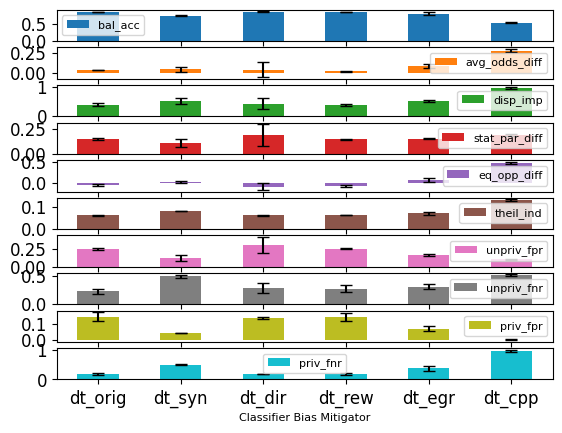

In [24]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
egr_error_metrics = {k: [statistics.stdev(v)] for (k,v) in egr_metrics.items()}
pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
egr_metrics_mean = {k:[sum(v)/N] for (k,v) in egr_metrics.items()}
pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
from scipy.stats import ttest_rel
def paired_t (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
    return p

def acc_diff (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    delta = np_a - np_b
    m = statistics.mean(delta)
    s = statistics.stdev(delta)
    return [m, s]

if BASELINE == 'lr':
    plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, pr_orig_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, pr_orig_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print("5)")
    print(stat)
else:
    plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print(stat)

plt.show()

# Visualization

### Fairness

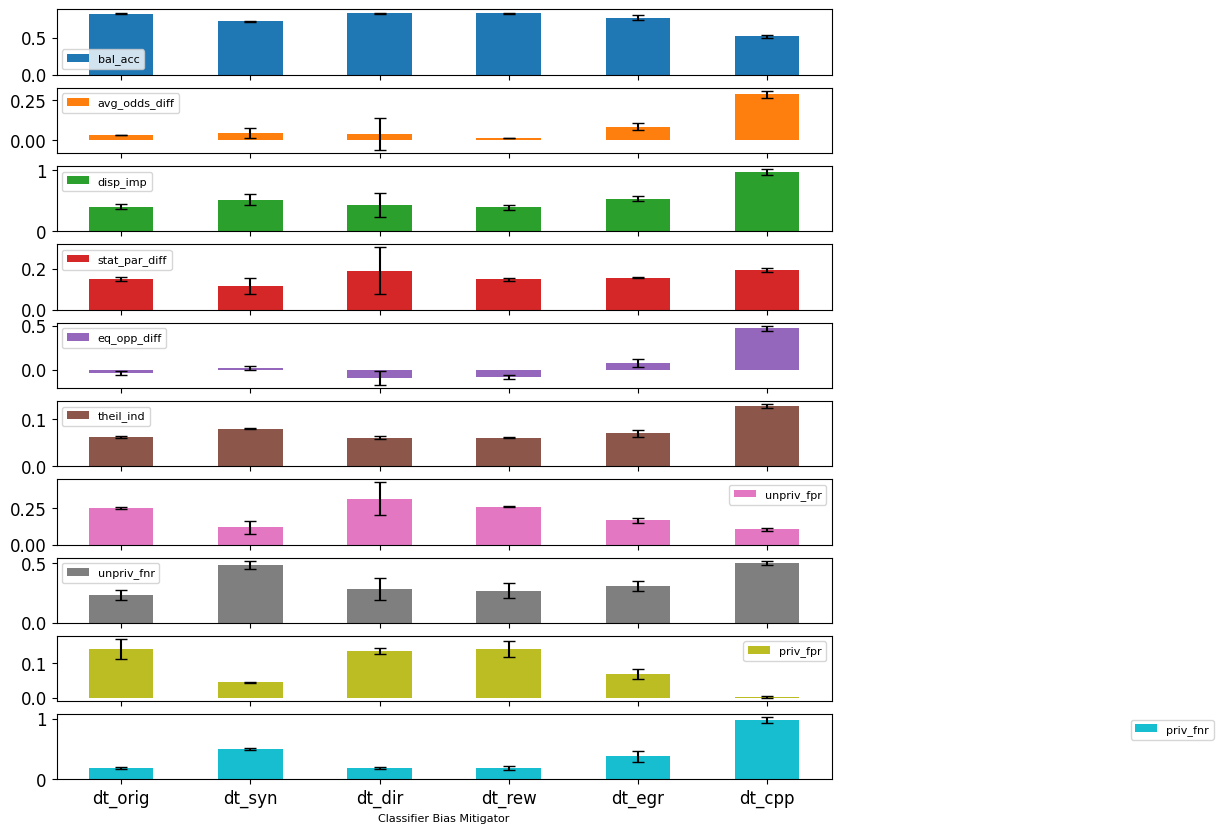

In [25]:
model_type = BASELINE
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_metrics_mean,
        transf_metrics_mean,
        dir_metrics_mean,
        reweigh_metrics_mean,
        egr_metrics_mean,
        pr_orig_metrics_mean,
        cpp_metrics_mean,
        ro_metrics_mean]


errors = [orig_error_metrics,
        transf_error_metrics,
        dir_error_metrics,
        reweigh_error_metrics,
        egr_error_metrics,
        pr_orig_error_metrics,
        cpp_error_metrics,
        ro_error_metrics]

index = pd.Series([model_type+'_orig']+ [model_type+'_syn']+ [model_type+'_dir']+ [model_type+'_rew']+ [model_type+'_egr'] + [model_type+'_cpp'], name='Classifier Bias Mitigator')

df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)
ax = df.plot.bar(yerr=df_error, capsize=4, rot=0, subplots=True, title=['','','','','', '', '', '', '', ''], fontsize = 12, figsize=(10,10))
plot1 = ax[0]
plot1.set_ylim=([0, 0.8])
plot2 = ax[1]
plot2.set_ylim=([-0.5, 0])
plot3 = ax[2]
plot3.set_ylim=([0, 1])
plot4 = ax[3]
plot4.set_ylim=([-0.5, 0])
plot5 = ax[4]
plot5.set_ylim=([-0.5, 0])
plot5 = ax[5]
plot5.set_ylim=([0, 0.2])

plt.legend(bbox_to_anchor=(1.5, 1.0))

In [26]:
df

,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind,unpriv_fpr,unpriv_fnr,priv_fpr,priv_fnr
Classifier Bias Mitigator,,,,,,,,,,
dt_orig,0.831615,0.033058,0.401825,0.150274,-0.043336,0.061477,0.252658,0.231746,0.143205,0.188410
dt_syn,0.726113,0.045875,0.520036,0.113562,0.016490,0.080400,0.119815,0.485714,0.044556,0.502204
dt_dir,0.833238,0.041088,0.431978,0.190430,-0.094956,0.061068,0.313372,0.282540,0.136239,0.187584
dt_rew,0.832594,0.016387,0.397122,0.147388,-0.085173,0.061259,0.260432,0.269841,0.142484,0.184668
dt_egr,0.776259,0.084816,0.533624,0.155354,0.071456,0.070227,0.167713,0.307937,0.069537,0.379392
dt_cpp,0.524009,0.285294,0.972996,0.192421,0.468049,0.128803,0.104722,0.504762,0.002184,0.972811


## Visualization of MIA results

### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [27]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [28]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           egr_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,entire_dataset_label_0.0_mia_privacy_risk,entire_dataset_label_1.0_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,,,
orig,0.523200,0.513680,0.593802,0.540937,0.624232,0.513099,0.593305
syn,0.519767,0.511521,0.581959,0.563335,0.654306,0.510439,0.579834
dir,0.523692,0.516265,0.588798,0.583346,0.670162,0.515143,0.585522
rew,0.524173,0.514426,0.599289,0.541088,0.626005,0.514002,0.598847
egr,0.528131,0.517426,0.604458,0.566149,0.658561,0.516289,0.601380


In [29]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'entire_dataset_label_0.0_mia_privacy_risk',
       'entire_dataset_label_1.0_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [30]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [31]:
df_groups

,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,
orig,0.540937,0.624232,0.513099,0.593305
syn,0.563335,0.654306,0.510439,0.579834
dir,0.583346,0.670162,0.515143,0.585522
rew,0.541088,0.626005,0.514002,0.598847
egr,0.566149,0.658561,0.516289,0.601380


<Axes: xlabel='Classifier MIA Attacks'>

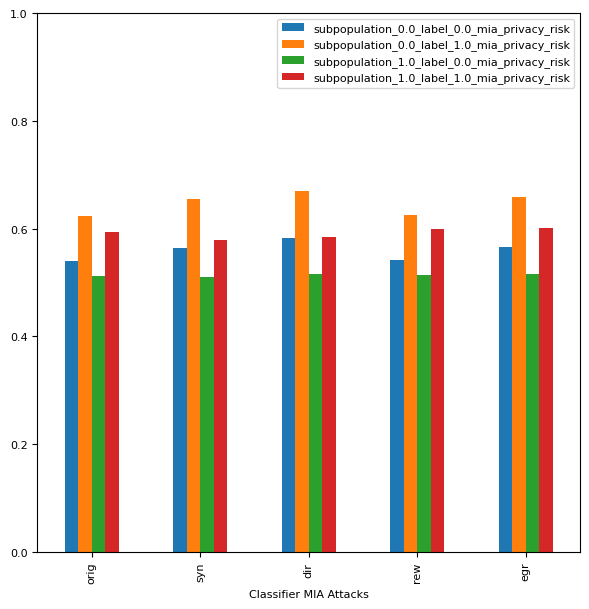

In [32]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [33]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew       egr
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.540937  0.563335  0.583346  0.541088  0.566149
subpopulation_0.0_label_1.0_mia_privacy_risk  0.624232  0.654306  0.670162  0.626005  0.658561
subpopulation_1.0_label_0.0_mia_privacy_risk  0.513099  0.510439  0.515143  0.514002  0.516289
subpopulation_1.0_label_1.0_mia_privacy_risk  0.593305  0.579834  0.585522  0.598847  0.60138


### Visualizing using novel technique

In [34]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [35]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])

In [36]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.525453
1,orig,entire_dataset_mia_privacy_risk,0.522074
2,orig,entire_dataset_mia_privacy_risk,0.522074
3,orig,entire_dataset_label_0.0_mia_privacy_risk,0.515220
4,orig,entire_dataset_label_0.0_mia_privacy_risk,0.512911
...,...,...,...
100,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.514982
101,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.514982
102,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.601667
103,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.601237


In [37]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.525453
1,orig,entire_dataset_mia_privacy_risk,0.522074
2,orig,entire_dataset_mia_privacy_risk,0.522074
9,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.530593
10,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.546109
...,...,...,...
100,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.514982
101,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.514982
102,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.601667
103,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.601237


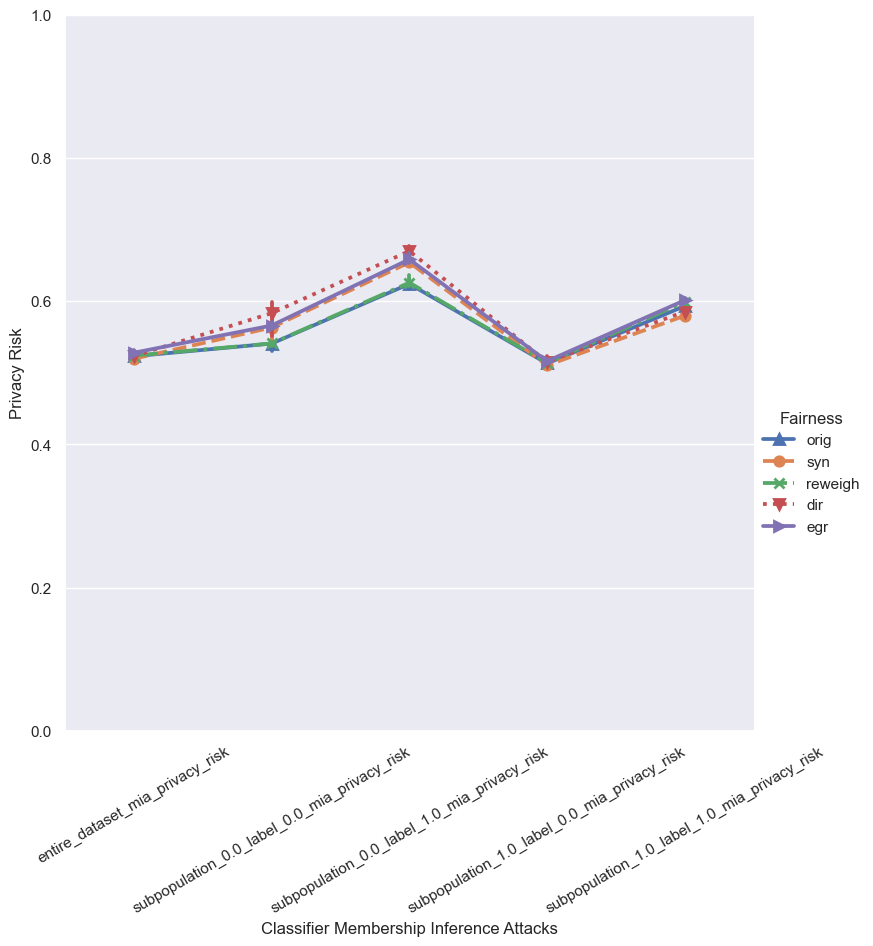

In [38]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [39]:
from sklearn.metrics import RocCurveDisplay, auc

In [40]:
orig_mia_metrics.keys()

dict_keys(['entire_dataset_mia_auc', 'entire_dataset_mia_privacy_risk', 'entire_dataset_mia_ppv', 'entire_dataset_mia_attacker_advantage', 'entire_dataset_mia_result', 'entire_dataset_label_0.0_mia_auc', 'entire_dataset_label_0.0_mia_privacy_risk', 'entire_dataset_label_0.0_mia_ppv', 'entire_dataset_label_0.0_mia_attacker_advantage', 'entire_dataset_label_0.0_mia_result', 'entire_dataset_label_1.0_mia_auc', 'entire_dataset_label_1.0_mia_privacy_risk', 'entire_dataset_label_1.0_mia_ppv', 'entire_dataset_label_1.0_mia_attacker_advantage', 'entire_dataset_label_1.0_mia_result', 'subpopulation_0.0_label_0.0_mia_auc', 'subpopulation_0.0_label_0.0_mia_privacy_risk', 'subpopulation_0.0_label_0.0_mia_ppv', 'subpopulation_0.0_label_0.0_mia_attacker_advantage', 'subpopulation_0.0_label_0.0_mia_result', 'subpopulation_0.0_label_1.0_mia_auc', 'subpopulation_0.0_label_1.0_mia_privacy_risk', 'subpopulation_0.0_label_1.0_mia_ppv', 'subpopulation_0.0_label_1.0_mia_attacker_advantage', 'subpopulation_0

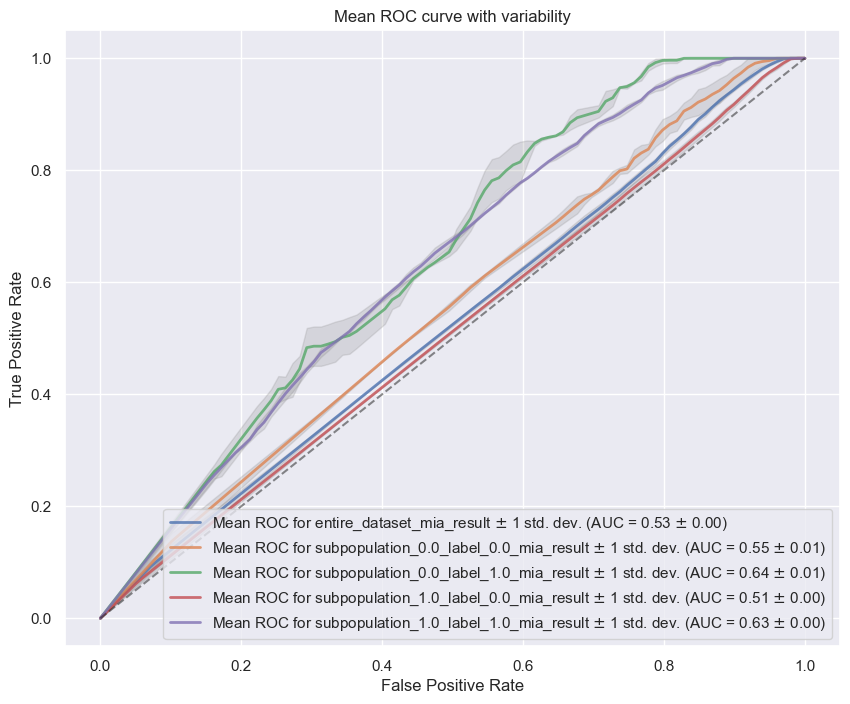

In [41]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result", "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

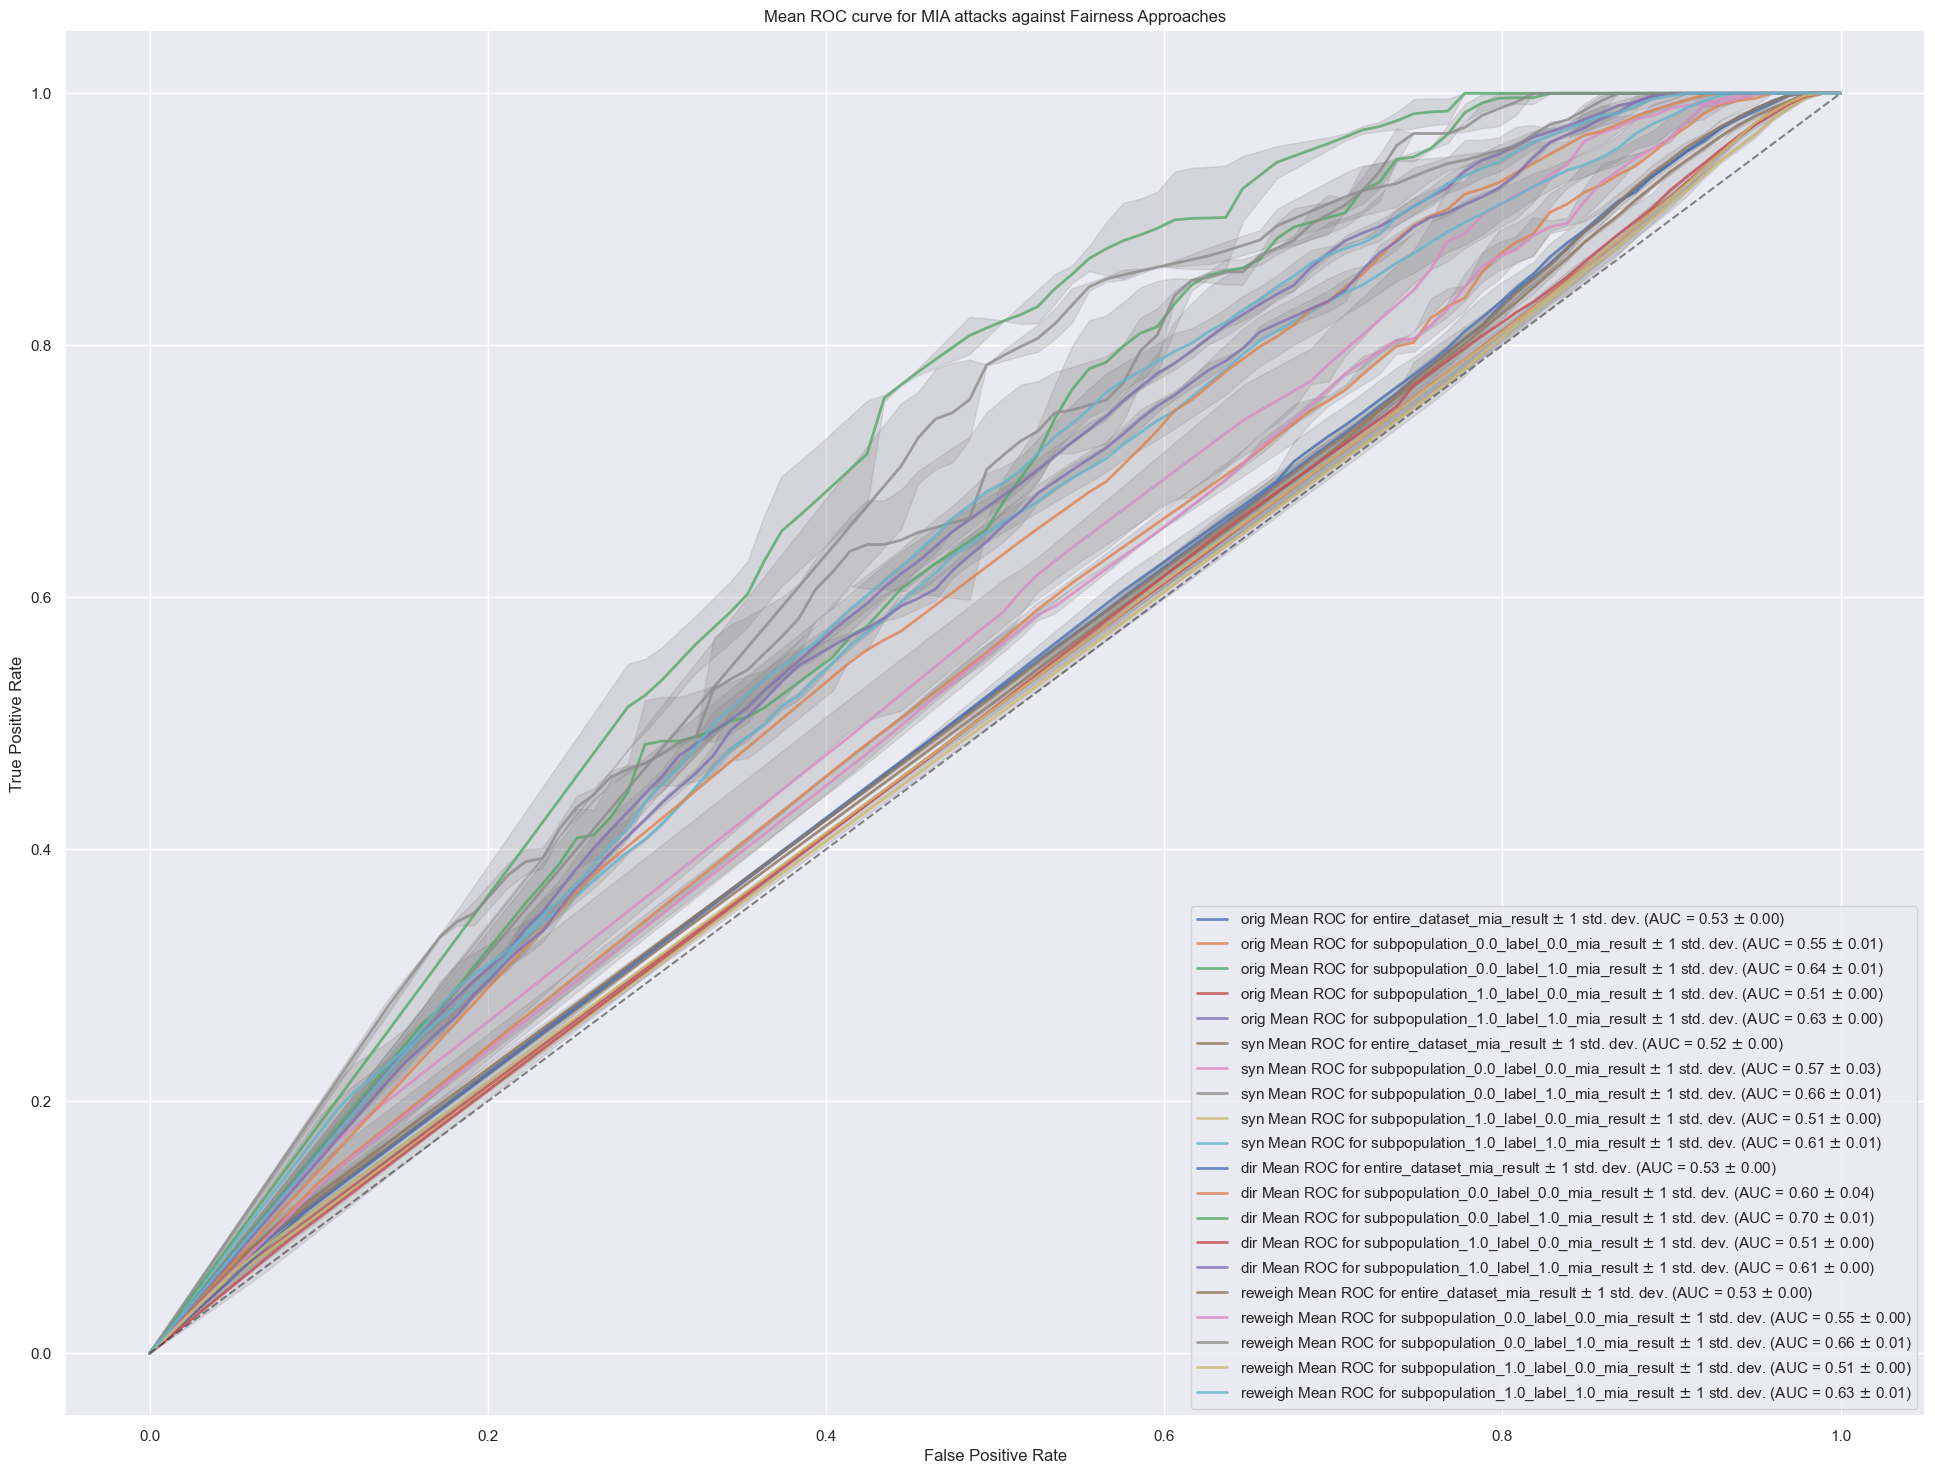

In [42]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics, dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

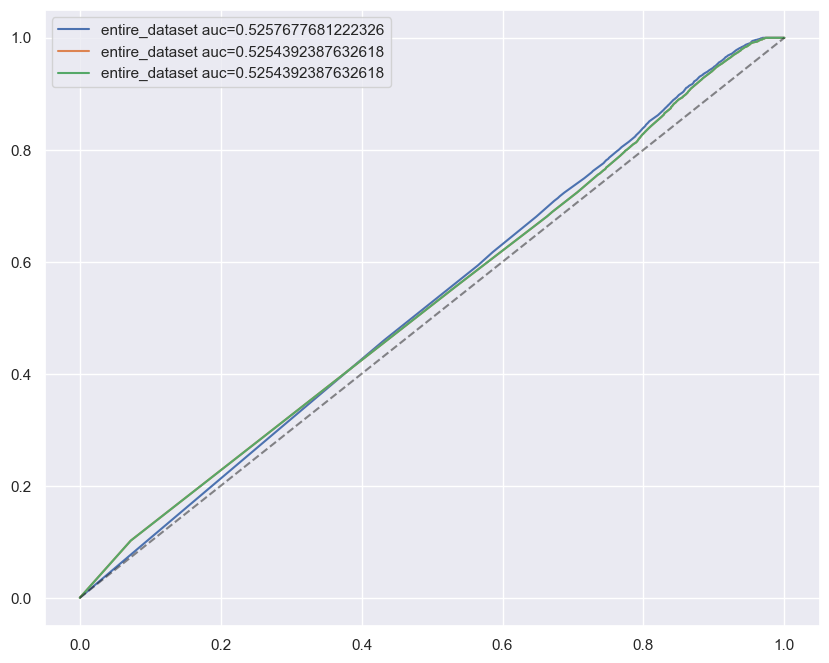

In [43]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [44]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("mia_auc")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("mia_auc")}

In [45]:
orig_mia_metrics_mean

{'entire_dataset_mia_auc': 0.5255487485495854,
 'entire_dataset_label_0.0_mia_auc': 0.5135401091096706,
 'entire_dataset_label_1.0_mia_auc': 0.6285543389285446,
 'subpopulation_0.0_label_0.0_mia_auc': 0.5518457851138536,
 'subpopulation_0.0_label_1.0_mia_auc': 0.6417764268828099,
 'subpopulation_1.0_label_0.0_mia_auc': 0.5125049964123867,
 'subpopulation_1.0_label_1.0_mia_auc': 0.6278998038506826}

In [46]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        egr_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_auc,entire_dataset_label_0.0_mia_auc,entire_dataset_label_1.0_mia_auc,subpopulation_0.0_label_0.0_mia_auc,subpopulation_0.0_label_1.0_mia_auc,subpopulation_1.0_label_0.0_mia_auc,subpopulation_1.0_label_1.0_mia_auc
Classifier MIA Attacks,,,,,,,
orig,0.525549,0.513540,0.628554,0.551846,0.641776,0.512505,0.627900
syn,0.521405,0.509421,0.611791,0.574073,0.661601,0.507694,0.608729
dir,0.526229,0.516056,0.617424,0.603178,0.695171,0.513303,0.612984
rew,0.525798,0.514514,0.630509,0.549456,0.657717,0.513580,0.628954
egr,0.528988,0.517742,0.618641,0.566285,0.664083,0.516472,0.616036


<Axes: xlabel='Classifier MIA Attacks'>

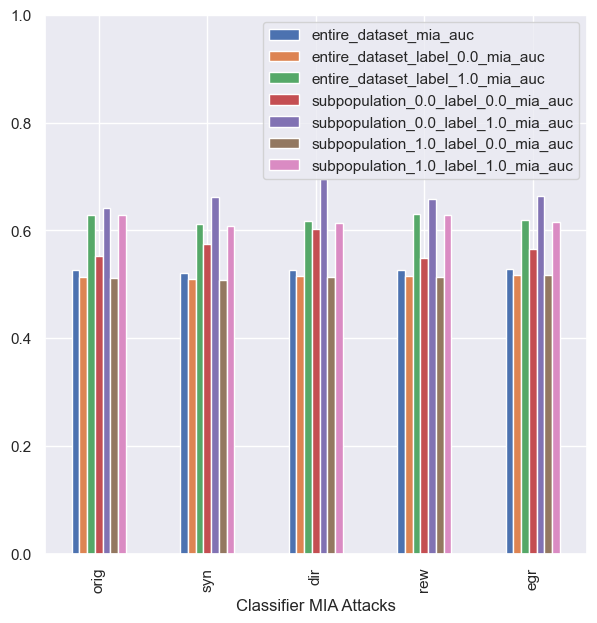

In [47]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [48]:
# Creating data structures to plot point categorical plot from seaborn

In [49]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("attacker_advantage")}

In [50]:
orig_mia_metrics_att_ad

{'entire_dataset_mia_attacker_advantage': [0.05090527420624502,
  0.044148517449488334,
  0.044148517449488334],
 'entire_dataset_label_0.0_mia_attacker_advantage': [0.030439738779765024,
  0.025821590364842772,
  0.025821590364842772],
 'entire_dataset_label_1.0_mia_attacker_advantage': [0.18996550946072266,
  0.1864243139302857,
  0.1864243139302857],
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': [0.061185330002534344,
  0.09221701102801372,
  0.09221701102801372],
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': [0.23313069908814588,
  0.25612968591691987,
  0.25612968591691987],
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': [0.03008197455908268,
  0.02425695461893418,
  0.02425695461893418],
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': [0.19141374914559434,
  0.18420743743375112,
  0.18420743743375112]}

In [51]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.05090527420624502],
 ['orig', 'entire_dataset', 0.044148517449488334],
 ['orig', 'entire_dataset', 0.044148517449488334],
 ['orig', 'entire_dataset_label_0.0', 0.030439738779765024],
 ['orig', 'entire_dataset_label_0.0', 0.025821590364842772],
 ['orig', 'entire_dataset_label_0.0', 0.025821590364842772],
 ['orig', 'entire_dataset_label_1.0', 0.18996550946072266],
 ['orig', 'entire_dataset_label_1.0', 0.1864243139302857],
 ['orig', 'entire_dataset_label_1.0', 0.1864243139302857],
 ['orig', 'subpopulation_0.0_label_0.0', 0.061185330002534344],
 ['orig', 'subpopulation_0.0_label_0.0', 0.09221701102801372],
 ['orig', 'subpopulation_0.0_label_0.0', 0.09221701102801372],
 ['orig', 'subpopulation_0.0_label_1.0', 0.23313069908814588],
 ['orig', 'subpopulation_0.0_label_1.0', 0.25612968591691987],
 ['orig', 'subpopulation_0.0_label_1.0', 0.25612968591691987],
 ['orig', 'subpopulation_1.0_label_0.0', 0.03008197455908268],
 ['orig', 'subpopulation_1.0_label_0.0', 0.02

In [52]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

,Fairness,MIA,attacker_advantage
0,orig,entire_dataset,0.050905
1,orig,entire_dataset,0.044149
2,orig,entire_dataset,0.044149
3,orig,entire_dataset_label_0.0,0.030440
4,orig,entire_dataset_label_0.0,0.025822
...,...,...,...
100,egr,subpopulation_1.0_label_0.0,0.029964
101,egr,subpopulation_1.0_label_0.0,0.029964
102,egr,subpopulation_1.0_label_1.0,0.203335
103,egr,subpopulation_1.0_label_1.0,0.202474


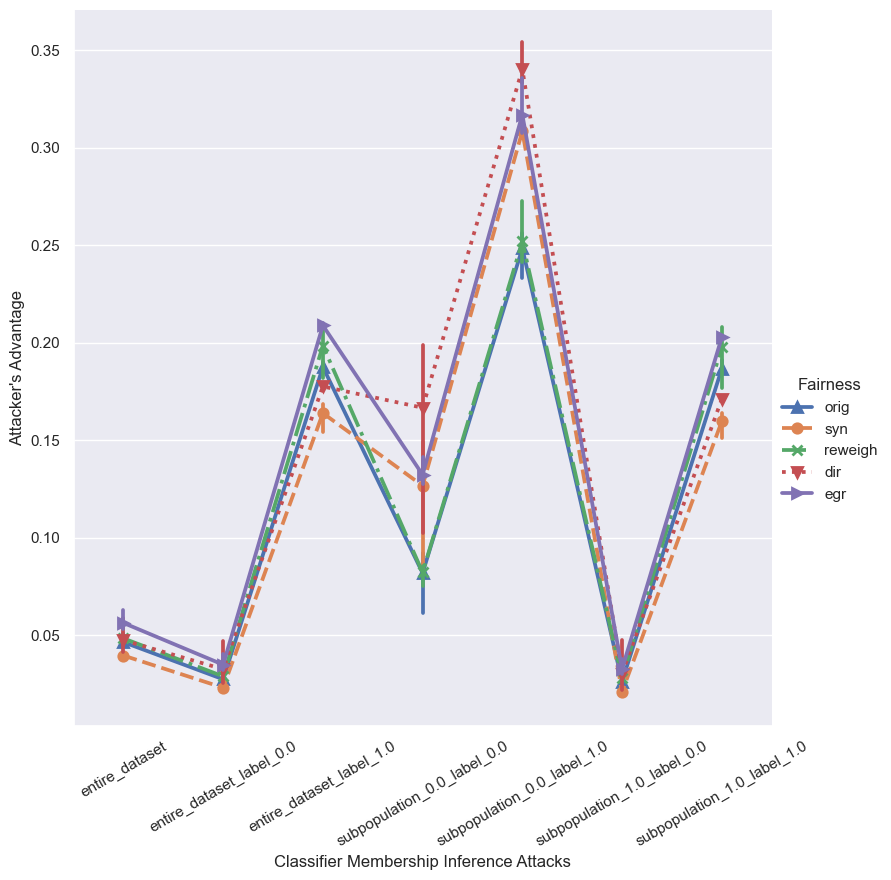

In [53]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


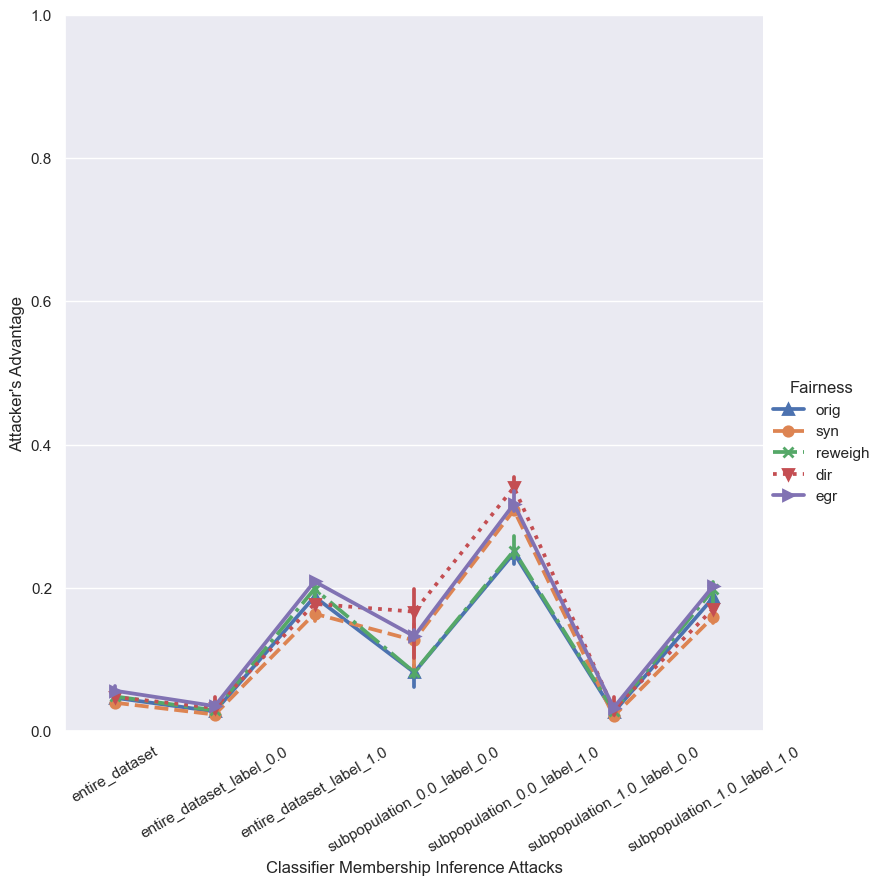

In [54]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [55]:
pd.DataFrame(orig_mia_metrics_att_ad)

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
0,0.050905,0.030440,0.189966,0.061185,0.233131,0.030082,0.191414
1,0.044149,0.025822,0.186424,0.092217,0.256130,0.024257,0.184207
2,0.044149,0.025822,0.186424,0.092217,0.256130,0.024257,0.184207


In [56]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("attacker_advantage")}

In [57]:
orig_mia_metrics_mean

{'entire_dataset_mia_attacker_advantage': 0.04640076970174056,
 'entire_dataset_label_0.0_mia_attacker_advantage': 0.027360973169816855,
 'entire_dataset_label_1.0_mia_attacker_advantage': 0.18760471244043134,
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': 0.08187311735285392,
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': 0.24846335697399521,
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': 0.026198627932317014,
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': 0.18660954133769883}

In [58]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           egr_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
Classifier MIA Attacks,,,,,,,
orig,0.046401,0.027361,0.187605,0.081873,0.248463,0.026199,0.186610
syn,0.039535,0.023042,0.163919,0.126671,0.308612,0.020877,0.159668
dir,0.047385,0.032530,0.177596,0.166691,0.340324,0.030286,0.171043
rew,0.048347,0.028852,0.198578,0.082176,0.252009,0.028004,0.197694
egr,0.056263,0.034853,0.208916,0.132299,0.317123,0.032579,0.202761


<Axes: xlabel='Classifier MIA Attacks'>

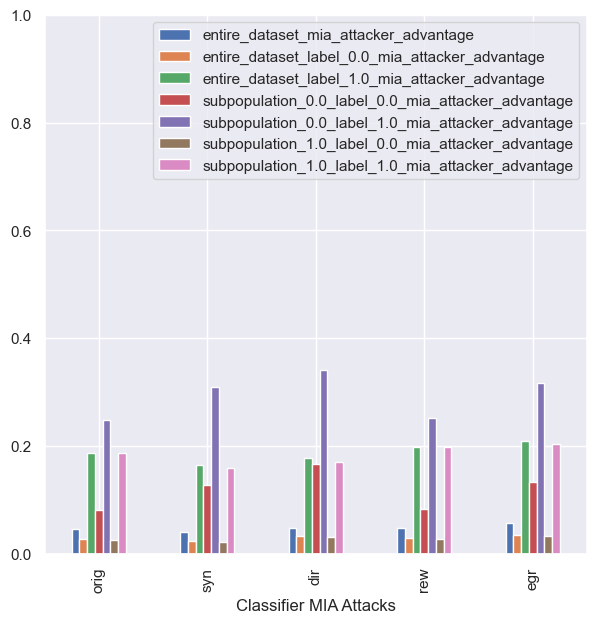

In [59]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [60]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("mia_ppv")}

In [61]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.5156904534430807],
 ['orig', 'entire_dataset', 0.5854025583145223],
 ['orig', 'entire_dataset', 0.5854025583145223],
 ['orig', 'entire_dataset_label_0.0', 0.509122095743022],
 ['orig', 'entire_dataset_label_0.0', 0.5692216280451574],
 ['orig', 'entire_dataset_label_0.0', 0.5692216280451574],
 ['orig', 'entire_dataset_label_1.0', 0.6235595390524967],
 ['orig', 'entire_dataset_label_1.0', 0.6155572176514585],
 ['orig', 'entire_dataset_label_1.0', 0.6155572176514585],
 ['orig', 'subpopulation_0.0_label_0.0', 0.5466666666666666],
 ['orig', 'subpopulation_0.0_label_0.0', 0.5783132530120483],
 ['orig', 'subpopulation_0.0_label_0.0', 0.5783132530120483],
 ['orig', 'subpopulation_0.0_label_1.0', 0.5750000000000001],
 ['orig', 'subpopulation_0.0_label_1.0', 0.6103896103896105],
 ['orig', 'subpopulation_0.0_label_1.0', 0.6103896103896105],
 ['orig', 'subpopulation_1.0_label_0.0', 0.5082228963755389],
 ['orig', 'subpopulation_1.0_label_0.0', 0.56875],
 ['orig', 'subp

In [62]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

,Fairness,MIA,PPV
0,orig,entire_dataset,0.515690
1,orig,entire_dataset,0.585403
2,orig,entire_dataset,0.585403
3,orig,entire_dataset_label_0.0,0.509122
4,orig,entire_dataset_label_0.0,0.569222
...,...,...,...
100,egr,subpopulation_1.0_label_0.0,0.507427
101,egr,subpopulation_1.0_label_0.0,0.507427
102,egr,subpopulation_1.0_label_1.0,0.598161
103,egr,subpopulation_1.0_label_1.0,0.614319


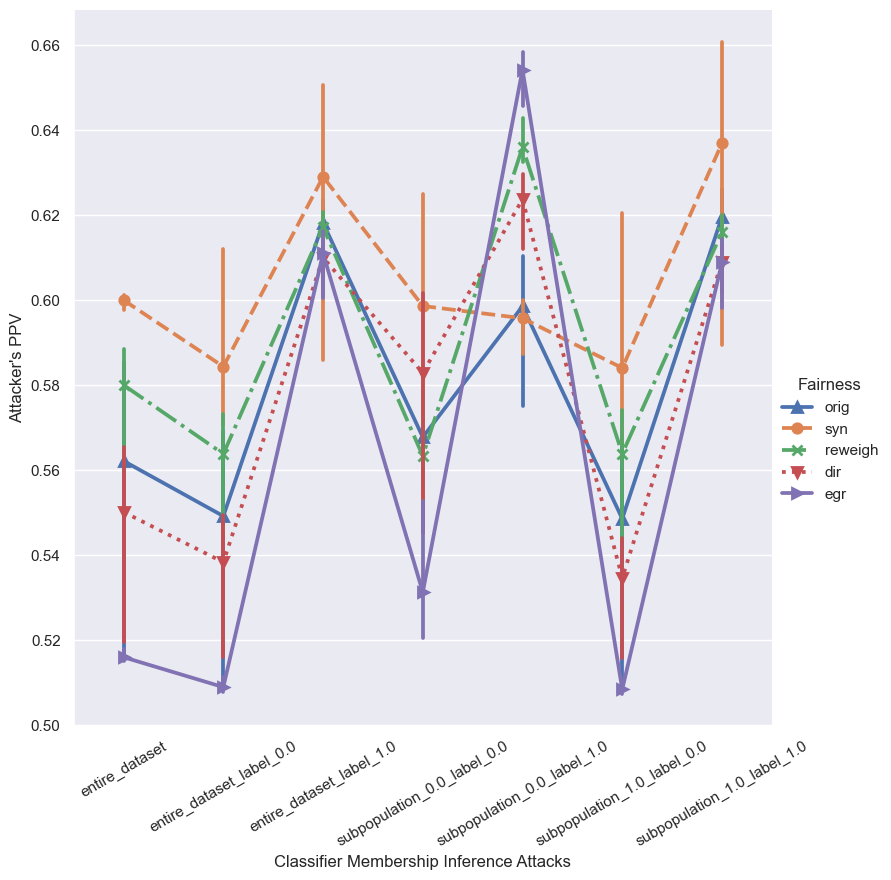

In [63]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )


# Dataset Exploration for comparison with Shokri

In [64]:
import pandas as pd

In [65]:
# pd.DataFrame([dataset_orig.features, dataset_orig.labels]).drop_duplicates()

df = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)

df["labels"] = dataset_orig.labels
df
#df.index

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month=sep,day_of_week=fri,day_of_week=mon,day_of_week=thu,day_of_week=tue,day_of_week=wed,poutcome=failure,poutcome=nonexistent,poutcome=success,labels
0,1.0,261.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,226.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,151.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,307.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,139.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30483,1.0,334.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
30484,1.0,383.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30485,1.0,189.0,2.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30486,1.0,442.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [66]:
df[["age", "labels"]].value_counts(normalize=True)

age  labels
1.0  0.0       0.851614
1.0  1.0       0.120047
0.0  0.0       0.021812
0.0  1.0       0.006527
Name: proportion, dtype: float64

In [67]:
df.drop_duplicates()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month=sep,day_of_week=fri,day_of_week=mon,day_of_week=thu,day_of_week=tue,day_of_week=wed,poutcome=failure,poutcome=nonexistent,poutcome=success,labels
0,1.0,261.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,226.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,151.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,307.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,139.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30483,1.0,334.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
30484,1.0,383.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30485,1.0,189.0,2.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30486,1.0,442.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


## DT Accuracy

In [68]:
get_orig_model_metrics(dataset_orig_train, dataset_orig_test, unprivileged_groups, f_label, uf_label, BASELINE, SCALER)

[INFO]: training decision tree
Classification report for train: 


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       322
         1.0       0.00      0.00      0.00         0

    accuracy                           0.98       322
   macro avg       0.50      0.49      0.49       322
weighted avg       1.00      0.98      0.99       322

Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.67      0.80        94

    accuracy                           0.67        94
   macro avg       0.50      0.34      0.40        94
weighted avg       1.00      0.67      0.80        94

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     12971
         1.0       0.00      0.00      0.00         0

    accuracy                           0.98     12971
   macro avg       0.50      0.49      0.49     12971
weight

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

{'train_0_0': 0.9751552795031055,
 'train_0_1': 0.6702127659574468,
 'train_1_0': 0.9750212011410069,
 'train_1_1': 0.6973613354873451,
 'test_0_0': 0.9358600583090378,
 'test_0_1': 0.8095238095238095,
 'test_1_0': 0.9669822211960286,
 'test_1_1': 0.7842484747642817}